### Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import re
import PyComplexHeatmap
from PyComplexHeatmap import *
from PyComplexHeatmap import HeatmapAnnotation, anno_label, anno_simple, anno_boxplot, anno_scatterplot, anno_barplot, ClusterMapPlotter

In [2]:
#Define the path to directory
input_path = '../data/normal_yo_SCA/'
interim_path = '../data/interim/'

#filenames
input_filename = 'CERES_merge.csv'

In [3]:
# Load CSV file
data = pd.read_csv(input_path+input_filename)

In [4]:
# Group by "Phenotype" and calculate median and std for "Age"
age_stats = data.groupby("Phenotype")["Age"].agg(["median", "std"])

# Group by "Phenotype" and calculate the ratio of each "Sex" category
sex_ratio = data.groupby("Phenotype")["Sex"].value_counts(normalize=True).unstack(fill_value=0)

print("Age stats by Phenotype:")
print(age_stats)
print("\nSex ratio by Phenotype:")
print(sex_ratio)

Age stats by Phenotype:
           median        std
Phenotype                   
Control      73.0   6.356823
PCD          71.0  12.424316
SCA          49.0  15.600481

Sex ratio by Phenotype:
Sex          Female      Male
Phenotype                    
Control    1.000000  0.000000
PCD        1.000000  0.000000
SCA        0.470588  0.529412


In [5]:
data.index = ['Patient ' + str(i) for i in range(1, data.shape[0] + 1)]

In [6]:
# Extract the string part of the 'Phenotype' column (e.g., remove numbers)
data['Phenotype'] = data['Name'].apply(lambda x: re.sub(r'\d+', '', x).strip())

# Drop rows where 'Phenotype' contains 'Control'
data = data[~data['Phenotype'].str.contains('Normal', case=False)]

# Drop unnecessary columns: 'Patient ID', 'Report Date', 'Name'
data = data.drop(columns=['Patient ID', 'Report Date', 'Name'])

In [7]:
# Optional, can be commented out: Only use norm. thickness features

# Keep only columns that have 'thickness norm.' in the column header, plus Sex, Age, and phenotype columns
selected_columns = ['Sex', 'Age', 'Time after Diagnosis'] + [col for col in data.columns if 'norm.' in col or 'Phenotype' in col]
data = data[selected_columns]
data.columns = data.columns.str.replace(r'cortical thickness norm\.\s*', '', regex=True)

In [8]:
# List of columns to exclude from normalization
exclude_columns = ['Name', 'Phenotype', 'Patient ID', 'Sex', 'Age', 'Time after Diagnosis', 'Report Date', 'Scale factor', 'SNR', 'mSNR']

columns_to_normalize = data.columns.difference(exclude_columns)

# Fill NaNs with the mean or another appropriate value before z-scoring
data[columns_to_normalize] = data[columns_to_normalize].fillna(data[columns_to_normalize].mean())

# Apply z-score normalization
data_normalized = data.copy()
data_normalized[columns_to_normalize] = data[columns_to_normalize].apply(zscore)


### Feature Correlation

In [9]:
corr_mat = data_normalized[columns_to_normalize].corr().stack().reset_index(name="correlation")

corr_mat['Level']=corr_mat.correlation.apply(lambda x:'High' if x>=0.7 else 'Middle' if x >= 0.3 else 'Low')
data_plot = corr_mat.pivot(index='level_0',columns='level_1',values='correlation')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 112.03996428037428


/Users/tamara/anaconda3/envs/pcdanalysis/lib/python3.11/site-packages/PyComplexHeatmap/dotHeatmap.py:360: FutureWarning: The provided callable <function mean at 0x105a66fc0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data2d = data.pivot_table(
/Users/tamara/anaconda3/envs/pcdanalysis/lib/python3.11/site-packages/PyComplexHeatmap/dotHeatmap.py:409: FutureWarning: The provided callable <function mean at 0x105a66fc0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.kwargs["c"] = data.pivot_table(
/Users/tamara/anaconda3/envs/pcdanalysis/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Use

Plotting legends..
Estimated legend width: 7.5 mm


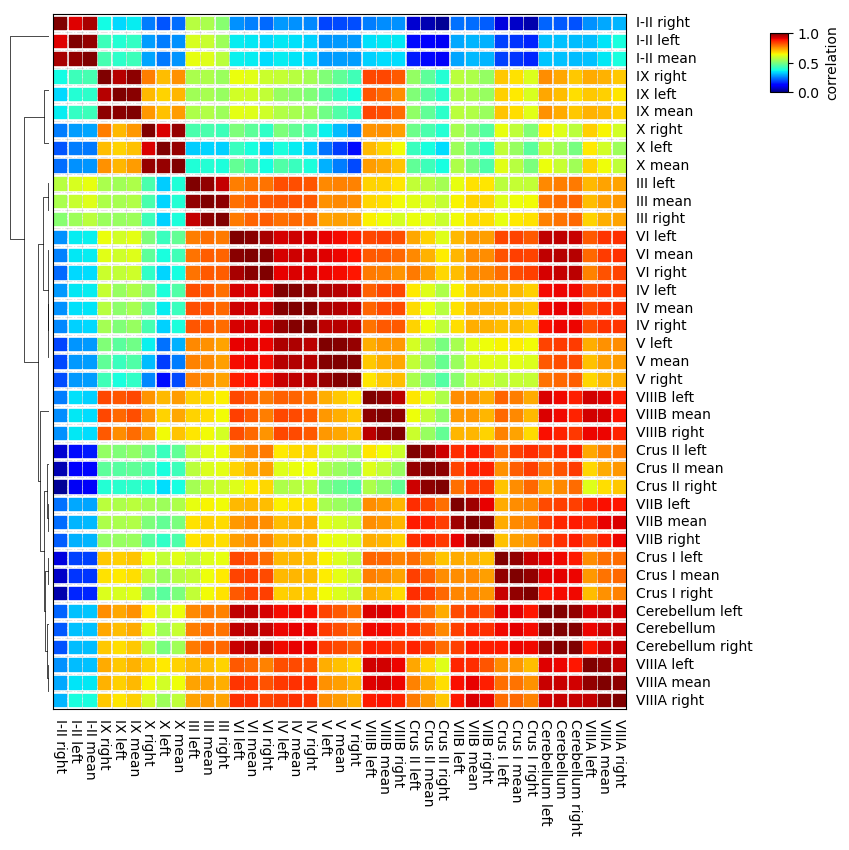

In [10]:
plt.figure(figsize=(8,8))
cm = DotClustermapPlotter(data=corr_mat,x='level_0',y='level_1',value='correlation',
              c='correlation',cmap='jet',vmax=1,vmin=0,s=0.7,marker='s',spines=True, show_rownames=True,show_colnames=True,row_dendrogram=True,
                          )
cm.ax_heatmap.grid(which='minor',color='white',linestyle='--',linewidth=1)
plt.show()

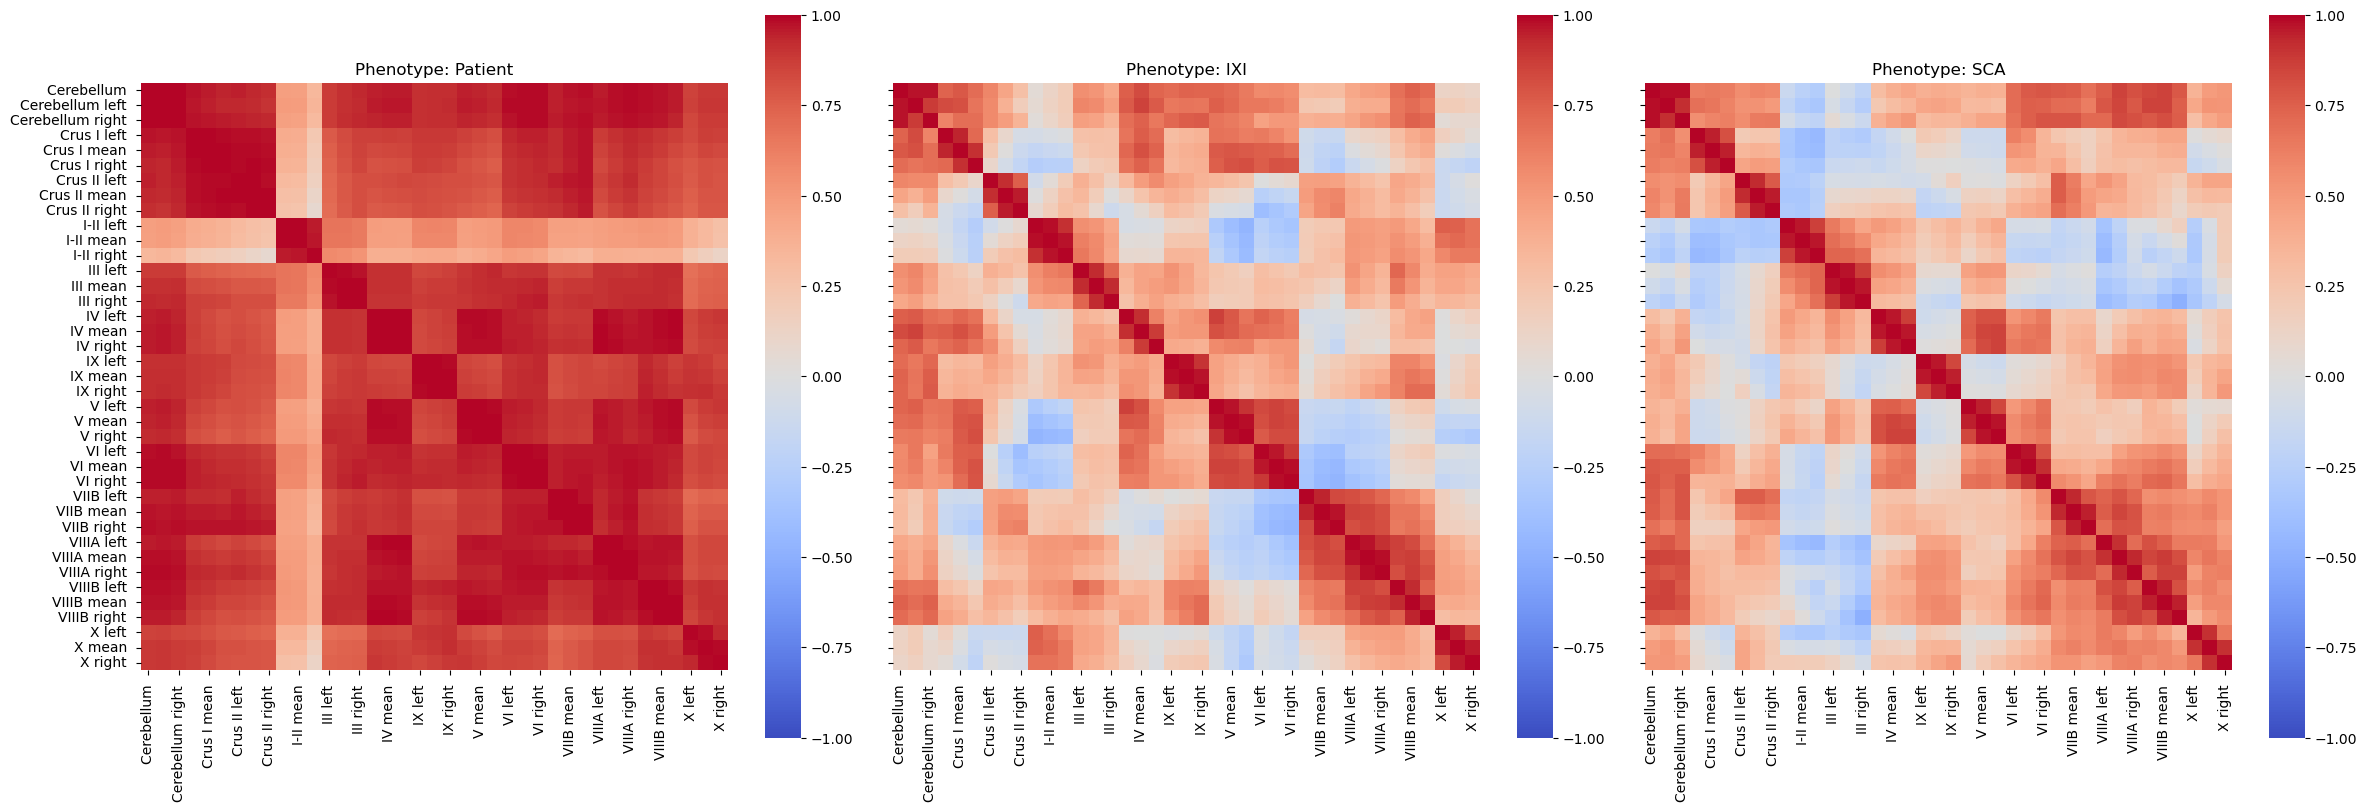

In [11]:
# Create three separate heatmaps, one for each unique Phenotype
phenotypes = data_normalized['Phenotype'].unique()
num_phenotypes = len(phenotypes)

fig, axes = plt.subplots(1, num_phenotypes, figsize=(24, 8), sharex=True, sharey=True)

for i, phenotype in enumerate(phenotypes):
    # Filter data for the specific phenotype
    phenotype_data = data_normalized[data_normalized['Phenotype'] == phenotype]
    
    # Calculate correlation matrix
    corr_mat = phenotype_data[columns_to_normalize].corr()
    
    # Plot heatmap for this phenotype
    sns.heatmap(corr_mat, ax=axes[i], cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True, annot=False)
    axes[i].set_title(f'Phenotype: {phenotype}')
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].tick_params(axis='y', rotation=0)
    
plt.tight_layout()
plt.show()

### Clustermap

In [12]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.family']='sans serif'
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['pdf.fonttype']=42

In [13]:
# Prepare the data for heatmap
df_heatmap = data_normalized[columns_to_normalize].T
df_box = data_normalized[["Age"]]
df = data_normalized.copy()
df_box.fillna(df_box.mean(), inplace=True)

/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40864/1182860324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_box.fillna(df_box.mean(), inplace=True)


In [14]:
# Assuming `df_heatmap` has the feature names as index
feature_names = df_heatmap.index

# Define a function to extract spatial labels from feature names
def extract_spatial_info(name):
    name = name.lower()  # Convert to lowercase for uniformity
    if "left" in name:
        return "left"
    elif "right" in name:
        return "right"
    else:
        return "mean"

# Apply the function to extract spatial information for each feature
spatial_labels = feature_names.map(extract_spatial_info)

# Convert the result to a pandas Series
spatial_labels_series = pd.Series(spatial_labels, index=feature_names, name="SpatialInfo")


In [15]:
df_boxplot = data.copy()
df_boxplot.reset_index(inplace=True)
df_boxplot.rename(columns={'index': 'Patient'}, inplace=True)
df_boxplot = pd.melt(df_boxplot,id_vars=['Patient', 'Age', 'Time after Diagnosis', 'Phenotype', 'Sex'], var_name='Lobule', value_name='Thickness')

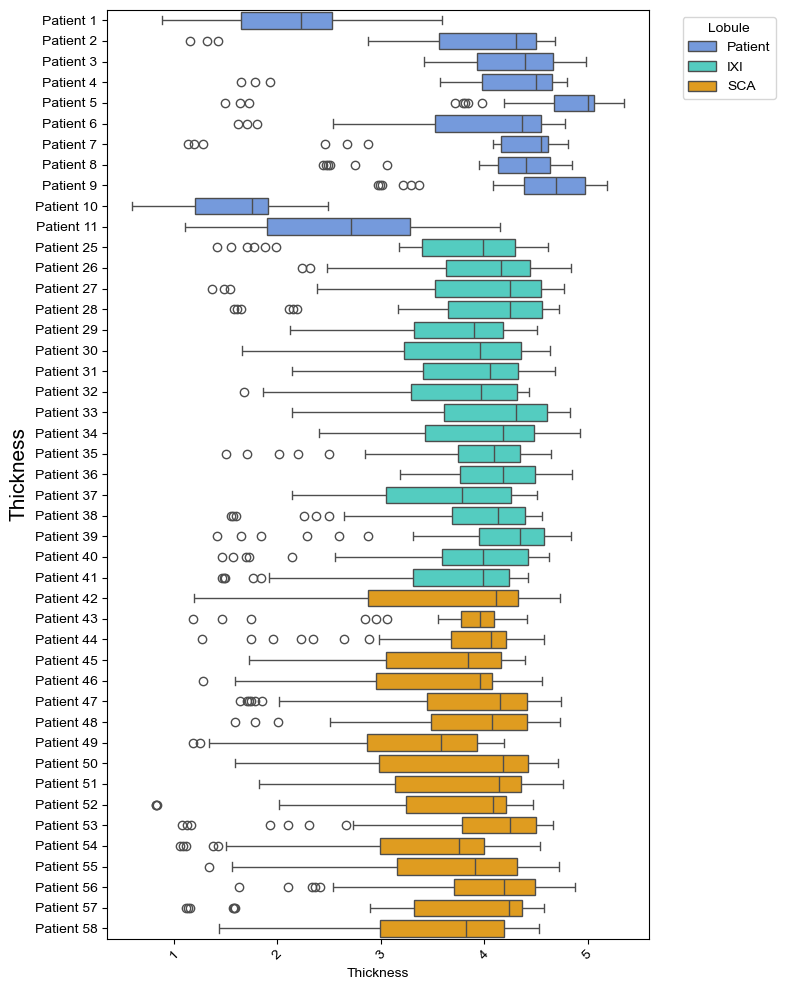

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(8, 10))

custom_palette = {'Patient': 'cornflowerblue', 'IXI': 'turquoise', 'SCA': 'orange'}

# Step 4: Create a boxplot showing lobule thickness for each patient
sns.boxplot(y='Patient', x='Thickness', hue='Phenotype', data=df_boxplot, palette=custom_palette)

# Step 5: Customize the plot
#plt.title("Lobule Thickness for Each Patient", fontsize=20)
#plt.xlabel("Patient", fontsize=15)
plt.ylabel("Thickness", fontsize=15)
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='Lobule', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 6: Show the plot
plt.tight_layout()
plt.show()

plt.savefig('../results/box.png')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


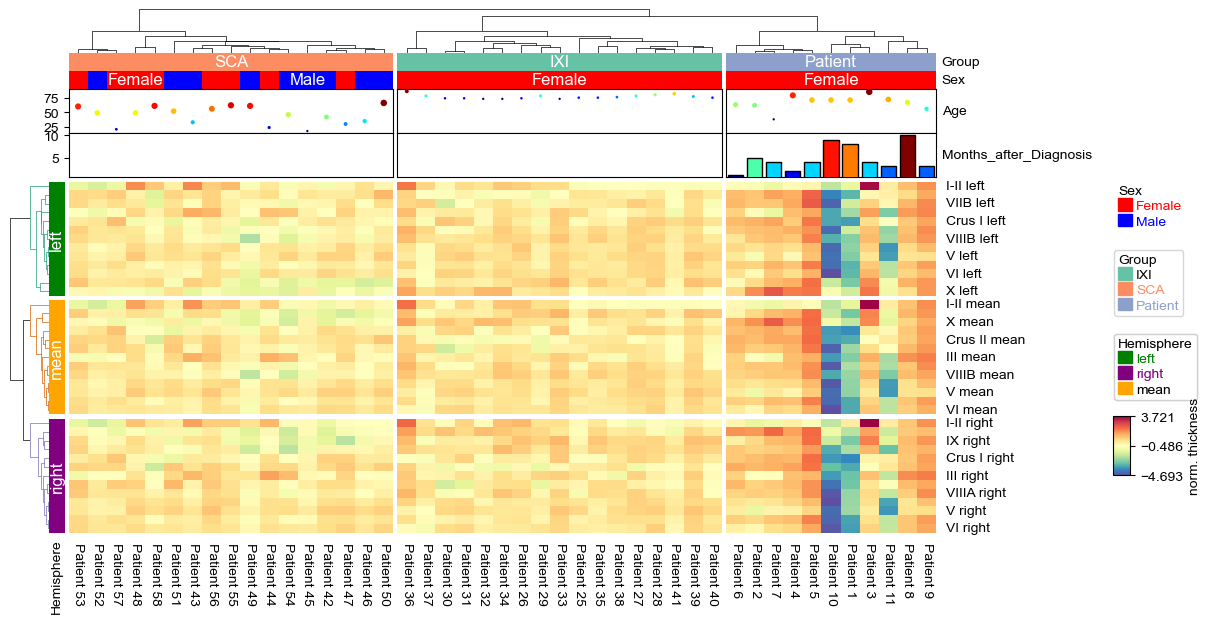

In [17]:
df_age = df['Age'].copy()
df_delay = df['Time after Diagnosis'].copy()
df_rows = spatial_labels_series.copy()
col_split = df['Phenotype'].copy()

plt.figure(figsize=(12, 6))
col_ha = HeatmapAnnotation(#label=anno_label(df.Phenotype, merge=True,rotation=15),
                           Group=anno_simple(df.Phenotype,add_text=True,cmap='Set2',text_kws={'fontsize':12},height=4),
                           axis=1,
                           Sex=anno_simple(df.Sex,add_text=True,colors={'Female':'red','Male':'blue'},
                                            legend_kws={'frameon':False},text_kws={'fontsize':12},height=4),
                           Age=anno_scatterplot(df_age,height=10, legend= False),
                           Months_after_Diagnosis=anno_barplot(df_delay,height=10, legend= False)
                           )

# Create the row annotation based on the spatial labels
row_ha = HeatmapAnnotation(Hemisphere=anno_simple(df_rows, add_text=True, 
                                                   colors={'left': 'green', 'right': 'purple', 'mean': 'orange'},
                                                   text_kws={'fontsize':12},height=4),
                           label_side='bottom', 
                           axis=0
)


cm = ClusterMapPlotter(data=df_heatmap, top_annotation=col_ha,left_annotation=row_ha,
                     label='norm. thickness',row_dendrogram=True,col_dendrogram=True,show_rownames=True,show_colnames=True,
                     tree_kws={'row_cmap': 'Dark2'},cmap='Spectral_r',
                     col_split_gap=1,row_split_gap=1,
                     col_split = col_split, row_split=df_rows,
                       legend_gap=5,legend_hpad=5,legend_vpad=5)
#legend_gap is the gap between two legends, legend_hpad is the horizonal space between legend and heatmap, legend_vpad
# is the verticall space between the first legend and the top of axes (legend_anchor).
# cm.ax_heatmap.set_axis_off()
plt.savefig('../results/heatmap_cluster.svg', bbox_inches='tight')
plt.show()



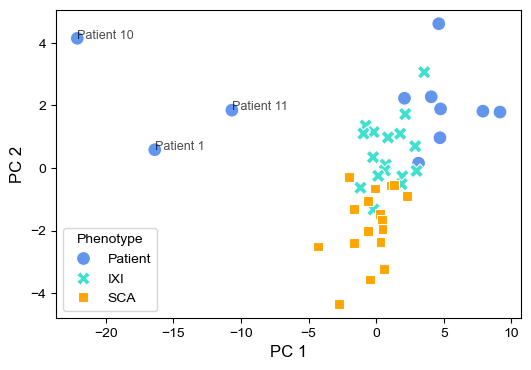

In [18]:
from sklearn.decomposition import PCA

df_heatmap_pca = df_heatmap.T  # Transpose to have samples as rows

# Perform PCA
pca = PCA(n_components=2)  # We want the first two components
pca_result = pca.fit_transform(df_heatmap_pca)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add Phenotype labels to the PCA DataFrame
pca_df['Phenotype'] = df['Phenotype'].values

# Add sample IDs (column names) as labels
pca_df['Sample_ID'] = df_heatmap.columns

# Plot the PCA
plt.figure(figsize=(6, 4))

custom_palette = {'Patient': 'cornflowerblue', 'IXI': 'turquoise', 'SCA': 'orange'}

# Create a scatter plot with points colored by Phenotype
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Phenotype', style='Phenotype', s=100, palette=custom_palette)

for i in [0,9,10]:
    plt.text(pca_df.PC1[i], pca_df.PC2[i], pca_df.Sample_ID[i], fontsize=9, alpha=0.7)


# Set plot labels and title
plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PC 2', fontsize=12)

# Display legend
plt.legend(title='Phenotype')

# Show plot
plt.show()


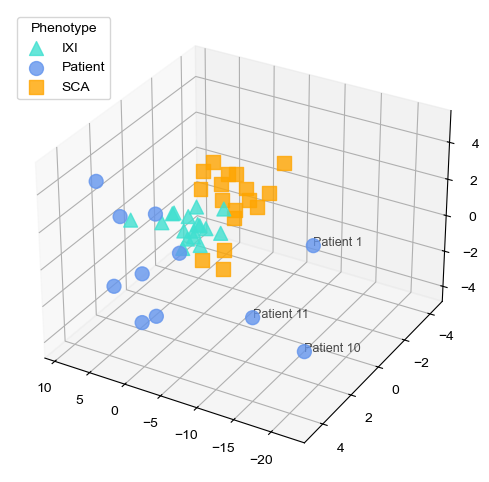

<Figure size 640x480 with 0 Axes>

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df_heatmap and df are already defined

# Transpose to have samples as rows
df_heatmap_pca = df_heatmap.T  

# Perform PCA
pca = PCA(n_components=3)  # We want the first three components for 3D
pca_result = pca.fit_transform(df_heatmap_pca)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Add Phenotype labels to the PCA DataFrame
pca_df['Phenotype'] = df['Phenotype'].values

# Add sample IDs (column names) as labels
pca_df['Sample_ID'] = df_heatmap.columns

# Set up 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Define a custom palette for phenotypes
custom_palette = {'Patient': 'cornflowerblue', 'IXI': 'turquoise', 'SCA': 'orange'}

# Map colors and styles
colors = pca_df['Phenotype'].map(custom_palette)
styles = {'Patient': 'o', 'IXI': '^', 'SCA': 's'}  # Different marker styles
markers = pca_df['Phenotype'].map(styles)

# Plot each phenotype group with unique marker and color
for phenotype, group in pca_df.groupby('Phenotype'):
    ax.scatter(
        group['PC1'], group['PC2'], group['PC3'],
        label=phenotype,
        color=custom_palette[phenotype],
        marker=styles[phenotype],
        s=100,
        alpha=0.8
    )

# Add sample labels for selected points
for i in [0, 9, 10]:  # Adjust indices as needed
    ax.text(
        pca_df.PC1[i], pca_df.PC2[i], pca_df.PC3[i],
        pca_df.Sample_ID[i],
        fontsize=9,
        alpha=0.7
    )

# Set labels
#ax.set_xlabel('PC1', fontsize=12)
#ax.set_ylabel('PC2', fontsize=12)
#ax.set_zlabel('PC3', fontsize=12)

ax.view_init(elev=30, azim=120)

# Add legend
ax.legend(title='Phenotype', loc='upper left', fontsize=10)

# Show plot
plt.show()


plt.savefig('../results/pca.svg', bbox_inches='tight')

In [20]:
from sklearn.cluster import KMeans

data_scaled = df_heatmap.T

k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)

cluster_centers = kmeans.cluster_centers_

kmeans_labels = kmeans.labels_

/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40864/3825165069.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis', len(set(kmeans_labels)))


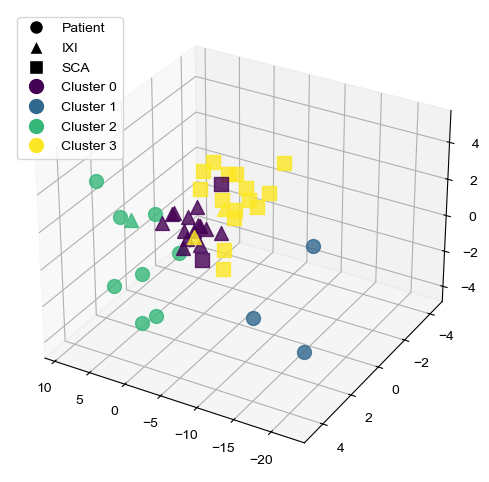

<Figure size 640x480 with 0 Axes>

In [21]:
from matplotlib import cm

# Transpose to have samples as rows
df_heatmap_pca = df_heatmap.T  

# Perform PCA
pca = PCA(n_components=3)  # We want the first three components for 3D
pca_result = pca.fit_transform(df_heatmap_pca)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Add clustering labels to the PCA DataFrame
pca_df['Cluster'] = kmeans_labels

# Add Phenotype labels to the PCA DataFrame
pca_df['Phenotype'] = df['Phenotype'].values

# Add sample IDs (column names) as labels
pca_df['Sample_ID'] = df_heatmap.columns

# Define a custom colormap for clusters
colormap = cm.get_cmap('viridis', len(set(kmeans_labels)))

# Define marker styles for phenotypes
styles = {'Patient': 'o', 'IXI': '^', 'SCA': 's'}

# Set up 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot points with colors for clusters and markers for phenotypes
for _, row in pca_df.iterrows():
    ax.scatter(
        row['PC1'], row['PC2'], row['PC3'],
        color=colormap(row['Cluster']),  # Color by cluster
        marker=styles[row['Phenotype']],  # Marker style by phenotype
        s=100,  # Adjust point size
        alpha=0.8  # Transparency
    )

# Customize the view angle
ax.view_init(elev=30, azim=120)

# Add a legend for phenotypes
phenotype_handles = [
    plt.Line2D([0], [0], marker=styles[phenotype], color='w', markerfacecolor='k', markersize=10, label=phenotype)
    for phenotype in styles
]
cluster_handles = [
    plt.Line2D([0], [0], marker='o', color=colormap(i), linestyle='', markersize=10, label=f'Cluster {i}')
    for i in range(len(set(kmeans_labels)))
]
legend_handles = phenotype_handles + cluster_handles
ax.legend(handles=legend_handles, loc='upper left', fontsize=10)

# Show plot
plt.show()

plt.savefig('../results/pca_clustered.svg', bbox_inches='tight')
